# Neuro-AI: Representational Similarity Analysis

---


# Tutorial Day 2 - Representational Similarrity Analysis

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1wOwyPqY3X-pSIiRHk3wsv1zAhGtkHbRO?usp=sharing)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1-WDElsPrfl-UJqwB6xM7HFYVkBiP2qiC) -->


> By Giacomo Aldegheri, Wieger Scheurer and Julio Smidi


In the first part of this tutorial, we will look at *representational similarity analysis* (RSA, [original paper](https://www.frontiersin.org/articles/10.3389/neuro.06.004.2008/full)). RSA is a commonly used way to explore and analyse how different stimuli are represented. A big advantage of RSA is that it can compare these representations across different modalities of measurement (for example fMRI, EEG or behavioral responses) and even across subjects and species (humans, monkeys and also neural networks!).

For RSA we create a *representational (dis)similarity matrix* (RDM) for each entity, which are made by taking a (dis)similarity measure for the activity patterns between each stimulus pair. One often used measure for this is the correlation distance. With such an RDM, we can now directly compare this to any other RDM, to explore the representational structure differences!

In this tutorial, we will again use fMRI data from the 2023 Algonauts challenge. It is a subset of the Natural Scenes Dataset (NSD) only including the visual system. The full dataset includes ~30,000 images per subject, but here, to make computations quicker, we will only use 872 images that were seen by all subjects.

<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/rsa_overview.jpeg" alt="General RSA overview" width="1000"/>





This tutorial is heavily indebted to the following resources:

- [Algonauts 2023 Challenge tutorial](https://colab.research.google.com/drive/1bLJGP3bAo_hAOwZPHpiSHKlt97X9xsUw?usp=share_link#scrollTo=gjQrI9AlzDqG)
- [Deep NSD tutorial by Colin Conwell](https://colab.research.google.com/drive/1OalDuiQ6Dwg39XT-BkPMz2XAduPUxQtv?usp=sharing)
- Relating DCNN features with brain activity tutorial by Jessica Loke
- [Comparing brains and DNNs presentation by Martin Hebart](http://algonauts.csail.mit.edu/slides/Martin_Hebart-Comparing_Brains_and_DNNs.pdf)
- [RSA toolbox by the RSAgroup](https://rsatoolbox.readthedocs.io/en/latest/overview.html)
- [Ni-edu by Lukas Snoek](https://lukas-snoek.com/NI-edu/fMRI-pattern-analysis/week_3/rsa.html#categorical-rdms)
- [Voxelwise encoding tutorials by Matteo Visconti di Oleggio Castello (Gallant lab)](https://github.com/gallantlab/voxelwise_tutorials)


# Setup

## Installs and imports

In [ ]:
!pip install nilearn==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 18.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageOps
from collections import OrderedDict
from tqdm.notebook import tqdm
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn import datasets, plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms, models
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import pearsonr, spearmanr, rankdata
from scipy.spatial.distance import cosine
import random
import glob
import ast

In [ ]:
# Optional: uncomment if you want to use OpenAI's CLIP model:
#!pip install git+https://github.com/openai/CLIP.git
#import clip

## Quick notebook execution
It is possible that you will have to restart the notebook and execute it from scratch (e.g. sometimes the Runtime gets disconnected). Toggle this to skip execution of computationally intensive cells (e.g. 3D plots)

In [ ]:
quick_execution = False # @param {type:"boolean"}

## Set device
If you have the possibility, using the GPU (CUDA) runtime will make computations significantly faster. In Colab, you can press the arrow in the top-right next to the RAM and Disk icons, select "Change runtime type" and select the T4 GPU. In the free version of Colab the usage of this is limited however.

In [ ]:
device = 'cpu' #@param ['cpu', 'cuda'] {allow-input: true}
if device=='cuda':
    assert torch.cuda.is_available()
device = torch.device(device)

## Get data

First, you need to access the data from [this public folder](https://drive.google.com/drive/folders/1AjDOejWLjfXGkr-hK07SZJ_4ni1nypjw?usp=sharing). Before running this tutorial, you need to select the folder and choose "Add a shortcut to Drive". This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you will be able to access the content.

<img src='https://drive.google.com/uc?id=15TNjV__sWCcnBRlxbXNbJfpidx-C6nrk' width=500>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
main_dir = '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial' #@param {type:"string"}
fmri_dir = os.path.join(main_dir, 'fmri_data')

Mounted at /content/drive/


In [ ]:
assert os.path.isdir(main_dir)

In [ ]:
# The folders of all eight subjects should be there
os.listdir(fmri_dir)

['subj01',
 'subj02',
 'subj03',
 'subj04',
 'subj05',
 'subj06',
 'subj07',
 'subj08']

# Load and visualize the data

<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/breinvlam4.png" width="250"/>

The fMRI data consists of two ```.npy``` files:
- ```lh_training_fmri.npy```: the left hemisphere (LH) fMRI data.
- ```rh_training_fmri.npy```: the right hemisphere (RH) fMRI data.

Both files are 2D arrays, where each row is a stimulus image and each column is an fMRI vertex.


> For more information on the fMRI responses please check the [README.txt](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Ffile%2Fd%2F16oLCaDmUBZuT6z_VGKO-qzwidYDE77Sg%2Fview%3Fusp%3Dshare_link) file from the 2023 Algonauts Challenge.






In [ ]:
# @title Utilities to plot ROIs and activations

def get_roi_mask(roi, hemisphere, subj):

  subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

  # Define the ROI class based on the selected ROI
  if roi in ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4"]:
      roi_class = 'prf-visualrois'
  elif roi in ["EBA", "FBA-1", "FBA-2", "mTL-bodies"]:
      roi_class = 'floc-bodies'
  elif roi in ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"]:
      roi_class = 'floc-faces'
  elif roi in ["OPA", "PPA", "RSC"]:
      roi_class = 'floc-places'
  elif roi in ["OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words"]:
      roi_class = 'floc-words'
  elif roi in ["early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]:
      roi_class = 'streams'
  elif roi == 'all-vertices':
      roi_class = roi

  # Load the ROI brain surface maps
  fsaverage_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_fsaverage_space.npy')

  fsaverage_roi_class = np.load(fsaverage_roi_class_dir)

  if roi != 'all-vertices':
    challenge_roi_class_dir = os.path.join(subj_dir, 'roi_masks',
      hemisphere[0]+'h.'+roi_class+'_challenge_space.npy')

    challenge_roi_class = np.load(challenge_roi_class_dir)

    roi_map_dir = os.path.join(subj_dir, 'roi_masks',
        'mapping_'+roi_class+'.npy')
    roi_map = np.load(roi_map_dir, allow_pickle=True).item()

    # Select the vertices corresponding to the ROI of interest
    roi_mapping = list(roi_map.keys())[list(roi_map.values()).index(roi)]
    challenge_roi = np.asarray(challenge_roi_class == roi_mapping, dtype=int)
    fsaverage_roi = np.asarray(fsaverage_roi_class == roi_mapping, dtype=int)

    return challenge_roi, fsaverage_roi

  else:
    return None, fsaverage_roi_class


def plot_surf_map(subj=1, stat_map=None, hemi='left', roi=None, title=None):
  """
  Plot ROI or statistical
  """
  if roi in [None, 'all-vertices']:
    roi = 'all-vertices'

  challenge_roi, fsaverage_roi = get_roi_mask(roi, hemi, subj)

  # Map the fMRI data onto the brain surface map


  if stat_map is None:
    fsaverage_response = fsaverage_roi
    cmap = 'cool'
    colorbar = False
  else:
    fsaverage_response = np.zeros(len(fsaverage_roi))
    if roi != 'all-vertices':
      fsaverage_response[np.where(fsaverage_roi)[0]] = \
        stat_map[np.where(challenge_roi)[0]]
    else:
      fsaverage_response[np.where(fsaverage_roi)[0]] = \
        stat_map
    cmap = 'cold_hot'
    colorbar = True

  if title is None:
    title = roi+', '+hemi+' hemisphere'

  # Create the interactive brain surface map
  fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
  view = plotting.view_surf(
      surf_mesh=fsaverage['infl_'+hemi],
      surf_map=fsaverage_response,
      bg_map=fsaverage['sulc_'+hemi],
      threshold=1e-14,
      cmap=cmap,
      colorbar=colorbar,
      title=title
      )
  return view

In [ ]:
# @title Choose subject to visualize
subj = 2 #@param ["1", "2", "3", "4", "5", "6", "7", "8"] {type:"raw", allow-input: true}
subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

print('LH fMRI data shape:')
print(lh_fmri.shape)
print('(Stimulus images × LH vertices)')

print('\nRH fMRI data shape:')
print(rh_fmri.shape)
print('(Stimulus images × RH vertices)')

LH fMRI data shape:
(872, 19004)
(Stimulus images × LH vertices)

RH fMRI data shape:
(872, 20544)
(Stimulus images × RH vertices)


In [ ]:
# @title Visualize all vertices on a brain surface map
if not quick_execution:
  hemisphere = 'left' #@param ['left', 'right']
  view = plot_surf_map(subj=subj, hemi=hemisphere)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Visualize a chosen ROI on the surface
if not quick_execution:
  hemisphere = 'left' #@param ["left", "right"]
  roi = "ventral" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"]
  view = plot_surf_map(subj=subj, hemi=hemisphere, roi=roi)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

### Stimulus images

All images come from the [COCO dataset](https://cocodataset.org/#home) of natural scenes.

In [ ]:
stim_dir = os.path.join(main_dir, 'stimuli')

# Create lists will all training and test image file names, sorted
img_list = os.listdir(stim_dir)
img_list.sort()
print('Total n. of images: ' + str(len(img_list)))

Total n. of images: 872


In [ ]:
# @title Visualize the fMRI response to selected images
if not quick_execution:
  img = 10 #@param

  #Load the image
  img_file = os.path.join(stim_dir, img_list[img])
  this_img = Image.open(img_file).convert('RGB')

  plt.figure()
  plt.axis('off')
  plt.imshow(this_img)
  plt.title('Image: ' + str(img));

  stat_map = lh_fmri[img] if hemisphere == 'left' else rh_fmri[img]

  view = plot_surf_map(stat_map=stat_map, subj=subj, hemi=hemisphere)
else:
  view = 'Skipping plot (untoggle quick execution to show plot)'
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# @title Visualize the fMRI responses of a chosen ROI
if not quick_execution:

  img = 0 #@param
  hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}
  roi = "ventral" #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

  # Load the image
  img_file = os.path.join(stim_dir, img_list[img])
  this_img = Image.open(img_file).convert('RGB')

  # Plot the image
  plt.figure()
  plt.axis('off')
  plt.imshow(this_img)
  plt.title('Training image: ' + str(img+1));

  stat_map = lh_fmri[img] if hemisphere == 'left' else rh_fmri[img]

  view = plot_surf_map(stat_map=stat_map, subj=subj, hemi=hemisphere, roi=roi)

else:
  view = 'Skipping plot (untoggle quick execution to show plot)'

view

Output hidden; open in https://colab.research.google.com to view.

# Feature extraction



Here, we're going to extract the feature representations of our stimulus images across different layers of a Deep Convolutional Neural Network (DCNN). These networks process information in a hierarchical fashion, extracting different types of features from the input data. Early DCNN layers extract more low-level visual features (edges, shapes, simple textures), while later layers extract more high-level features (complex patterns, full objects). We can plot these so-called *featuremaps* to inspect how the input is represented across different hierarchical levels of the network:

<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/cnn_layers.png" width="250"/>

This progressive processing of visual abstraction is to some extent analogous to how bottom-up visual sensory information is processed in early visual cortex. Hence, they are well-suited for comparisons with neural activity evoked by these images.

In [ ]:
# @title Helper functions to obtain a model and extract its activations

def get_vision_model(whichmodel):
  """
  Get computer vision model. This function can be
  modified to return a custom model.
  """
  if whichmodel in ['alexnet', 'resnet50']:
    model = torch.hub.load('pytorch/vision:v0.10.0', whichmodel)
    preprocess = transforms.Compose([
      transforms.Resize((224,224)), # resize the images to 224x24 pixels
      transforms.ToTensor(), # convert the images to a PyTorch tensor
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalize the images color channels
    ])
  elif whichmodel=='clip':
    model, preprocess = clip.load("ViT-B/32")
  else:
    raise ValueError(f'Model {whichmodel} unknown!')

  return model, preprocess


def list_layers(model):
    """
    List all layers of the model with their names.
    """
    layers = []
    for name, mod in model.named_modules():
        layers.append(name)
    return layers


def register_hooks(model, target_layers):
    """
    Register hooks to extract features from specified layers.
    """
    if not isinstance(target_layers, list):
      target_layers = [target_layers]

    features = {}

    def get_hook(name):
        def hook(module, input, output):
            features[name] = output.detach()
        return hook

    for name, layer in model.named_modules():
        if name in target_layers:
            layer.register_forward_hook(get_hook(name))

    return features

In [ ]:
class FeatureExtractor():
    def __init__(self, modelname, device=device, target_layers=None):
        self.modelname = modelname
        self.device = device
        model, self.preprocess = get_vision_model(modelname)
        self.model = model.eval().to(self.device)
        if target_layers is not None:
            self.create_feature_extractor(target_layers)

    def create_feature_extractor(self, target_layers):
        self.target_layers = target_layers
        self.features = register_hooks(self.model, self.target_layers)

    def list_layers(self):
        return list_layers(self.model)

    def run_model(self, x):

        x = x.to(self.device)

        with torch.no_grad():
            _ = self.model.encode_image(x) if self.modelname=='clip' else self.model(x)

    def __call__(self, x):
        self.run_model(x)
        # features = [torch.flatten(l, start_dim=1) for l in self.features.values()]
        # features_dict = {}
        # for n, l in zip(self.target_layers, self.features.values()):
        #     features_dict[n] = torch.flatten(l, start_dim=1).detach().cpu().numpy()
        return self.features

## Create the feature extractor for a specified model and layer(s).

Please note that ```target_layers``` can be a list of layers as well. To find out what layers are available for a given model, you can do the following:



```
# Note that we don't pass the 'target_layers'
# as a parameter to add them later!
feat_extractor = FeatureExtractor(modelname, device=device)

feat_extractor.list_layers()
```
 After choosing one or multiple layers from the list, you can do:

```
feat_extractor.create_feature_extractor(target_layers)
```

Up to you to experiment and try different layers and models! You can search the literature for ideas.

---
####**Question:**
For some research, we might be more interested in a specific range of DCNN layers than in others. Can you think of a situation in which we'd only want to look at earlier layers of a DCNN?

**YOUR ANSWER HERE**

If we only want to look at early perceptions? Even right after retina?



### Choose model and layer
<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/DCNN_better.png" width="350"/>


In [ ]:
model, _  = get_vision_model('alexnet')
list_layers(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


['',
 'features',
 'features.0',
 'features.1',
 'features.2',
 'features.3',
 'features.4',
 'features.5',
 'features.6',
 'features.7',
 'features.8',
 'features.9',
 'features.10',
 'features.11',
 'features.12',
 'avgpool',
 'classifier',
 'classifier.0',
 'classifier.1',
 'classifier.2',
 'classifier.3',
 'classifier.4',
 'classifier.5',
 'classifier.6']

In [ ]:
modelname = 'alexnet' #@param ['alexnet', 'resnet50', 'clip'] {allow-input: true}
target_layers = ['features.2'] #@param {type: 'string'}

# Note that target_layers can be a list of strings.

In [ ]:
# Create the feature extractor
feat_extractor = FeatureExtractor(modelname, device=device, target_layers=target_layers)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
feat_extractor.target_layers

['features.2']

### Feature extraction function

In [ ]:
def extract_features(feature_extractor, dataloader):
    features = []
    features_dict = {layer: [] for layer in feature_extractor.target_layers}

    for _, d in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Extract features
        ft = feature_extractor(d)
        ft_stacked = torch.hstack([torch.flatten(l, start_dim=1) for l in ft.values()])
        features.append(ft_stacked.detach().cpu().numpy())

        # Append features for each layer separately
        for layer, layer_features in ft.items():
            # Flatten the features
            flattened_features = torch.flatten(layer_features, start_dim=1)
            features_dict[layer].append(flattened_features.detach().cpu().numpy())

    features_dict = {layer: np.vstack(layer_features) for layer, layer_features in features_dict.items()}

    return np.vstack(features), features_dict

## Create image dataset

<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/nsd_stimuli2.jpeg" width="350"/>

Here we create a class instance that allows us to load the stimulus images.

In [ ]:
class ImageDataset(Dataset):
    """
    Pytorch dataset that loads the images
    from our stimulus set.
    """
    def __init__(self, imgs_paths, idxs, transform, device=device):
        self.imgs_paths = np.array(imgs_paths)[idxs]
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # Preprocess the image and send it to the chosen device ('cpu' or 'cuda')
        if self.transform:
            img = self.transform(img).to(self.device)
        return img

### Split fMRI data into training and validation partitions

For classical RSA, we actually don't need to split our data into training and validation sets; after all, we are only correlating the data, so there is no regression of any kind happening. However, later we are going to do a reweighted RSA (rRSA), and for this we do need a training/validation split. For ease we therefore opt to do the split here already. This way we can also compare the classical RSA with the rRSA on the same amount of stimuli.

Feel free however to do the RSA with the training and validation sets together, you just need to append the fMRI and DCNN feature training and validation sets!

In [ ]:
rand_seed = 123 #@param
np.random.seed(rand_seed)

train_test_split = 90 # @param
# Calculate how many stimulus images correspond to 90% of the training data
num_train = int(np.round(len(img_list) / 100 * train_test_split))
# Shuffle all stimulus images
idxs = np.arange(len(img_list))
np.random.shuffle(idxs)

# Assign 90% of the shuffled stimulus images to the training partition,
# and 10% to the test partition
idxs_train, idxs_test = idxs[:num_train], idxs[num_train:]

print('Training stimulus images: ' + format(len(idxs_train)))
print('\nTest stimulus images: ' + format(len(idxs_test)))

Training stimulus images: 785

Test stimulus images: 87


In [ ]:
lh_fmri_train = lh_fmri[idxs_train]
lh_fmri_test = lh_fmri[idxs_test]
rh_fmri_train = rh_fmri[idxs_train]
rh_fmri_test = rh_fmri[idxs_test]

In [ ]:
batch_size = 100 #@param
# Get the paths of all image files
imgs_paths = sorted(list(Path(stim_dir).iterdir()))

# The DataLoaders contain the ImageDataset class
train_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_train, transform=feat_extractor.preprocess),
    batch_size=batch_size
)
test_imgs_dataloader = DataLoader(
    ImageDataset(imgs_paths, idxs_test, transform=feat_extractor.preprocess),
    batch_size=batch_size
)

## Extract features

Now, we can extract the feature space representations of our images from the chosen DCNN. The resulting matrices provide an insight into how the visual information is represented at different hierarchical levels of the neural network.


---



> **Beware:** this can take a while (+-10 min), depending on the chosen model and layer to extract features from.



---


In the meantime it can be worth briefly scanning over the following papers on brain alignment of DCNNs:

*Yamins & DiCarlo (2016): Using goal-driven deep learning models to understand
sensory cortex*

https://www.cs.jhu.edu/~ayuille/JHUcourses/ProbabilisticModelsOfVisualCognition2020/Lec15/YaminsNature2016.pdf

*Güçlü & van Gerven (2015): Deep Neural Networks Reveal a Gradient in the Complexity
of Neural Representations across the Ventral Stream*

https://www.jneurosci.org/content/jneuro/35/27/10005.full.pdf?ref=https://githubhelp.com

*Kriegeskorte (2015): Deep Neural Networks: A New Framework for Modeling Biological Vision and Brain Information Processing*

https://www.annualreviews.org/content/journals/10.1146/annurev-vision-082114-035447


In [ ]:
features_train = extract_features(feat_extractor, train_imgs_dataloader)[0]
features_test = extract_features(feat_extractor, test_imgs_dataloader)[0]

print('\nTraining images features:')
print(features_train.shape)
print('(Training stimulus images × features)')

print('\nValidation images features:')
print(features_test.shape)
print('(Validation stimulus images × features)')

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Training images features:
(785, 46656)
(Training stimulus images × features)

Validation images features:
(87, 46656)
(Validation stimulus images × features)


In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# RSA



## Constructing RDMs

Now that we have extracted the DCNN features, we can use those to compute *representational dissimilarity matrices* (RDMs). Differences in feature representations between stimuli can be compared, giving us a matrix that has a (dis)similarity score between each stimulus pair (and hence a diagonal of zeros). An advantage of these RDMs is that once constructed, they can easily be compared across modalities (e.g. DNN and fMRI response RDMs), regardless of the feature space in which input is provided. This invariance between feature spaces is one of the main reasons why RSA is such a useful method. It allows us to compare modalities that are measured in very distinct ways, producing very different types of data. RDMs eliminate the restrictions imposed by inherent differences between modality-specific data by transforming data into a new space that captures the underlying **representational geometry**.


Our data is currently of the shape (stimulus images x fMRI/DCNN features), but will take on the shape (stimulus images x stimulus images) once we compute our RDMs. Each column in our current data tells us how the corresponding image is represented when proccesed by the brain (in voxel activations --> fMRI features) or by a DCNN (in feature maps). When transforming our modality-specific features into RDMs, we are essentially looking at the pairwise differences in stimulus representation.

<img src="https://raw.githubusercontent.com/WiegerScheurer/rsa_neuroai/main/rdm.png" width="400"/>

Because these are relative differences, RSA is indifferent to the original feature space of our data. You could think of this as comparing the relation between  word pairs in different languages, expressed through distances between word vectors in embedding space. Similariy, we want to retain only the geometrical information encapsulated in the original feature space. To do so, we compute the pairwise distances between how stimuli are represented. We do this for every combination of stimuli, producing our stimuli x stimuli shaped RDM. Each element in this matrix thus represents how different those two stimuli are represented in their original feature space. Consequently, we can compare these representational geometric patterns across modalities.

---
####**Question:**
Can you think of data that RSA allows us to compare, previously either impractical or simply impossible?

eeg, MEG... different modalities / frequencies...

In [ ]:
def create_rdm(activations):
    """
    Function to create an RDM from response activations or features.
    """
    rdm = np.corrcoef(activations)
    return rdm

In [ ]:
# @title Create Subject RDM
rdm_lh_train = create_rdm(lh_fmri_train)
rdm_lh_test = create_rdm(lh_fmri_test)
rdm_rh_train = create_rdm(rh_fmri_train)
rdm_rh_test = create_rdm(rh_fmri_test)

print("\nTraining images left and right hemisphere RDM")
print(rdm_lh_train.shape)
print(rdm_rh_train.shape)
print('(Training stimulus images × Training stimulus images)')

print("\nValidation images left and right hemishpere RDM")
print(rdm_lh_test.shape)
print(rdm_rh_test.shape)
print('(Validation stimulus images × Validation stimulus images)')


Training images left and right hemisphere RDM
(785, 785)
(785, 785)
(Training stimulus images × Training stimulus images)

Validation images left and right hemishpere RDM
(87, 87)
(87, 87)
(Validation stimulus images × Validation stimulus images)


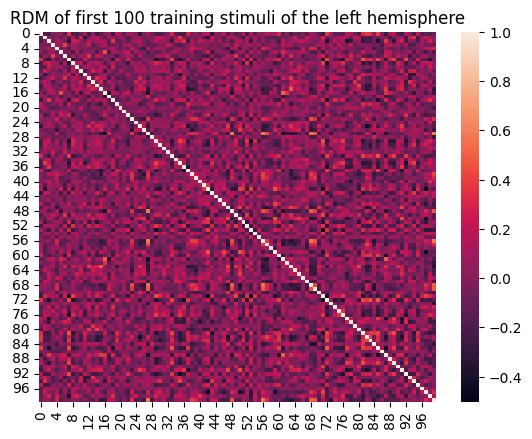

In [ ]:
# @title Plot subject RDM
plot_n_stimuli = 100 # @param
hemisphere = "left" # @param
sns.heatmap(rdm_lh_train[:plot_n_stimuli,:plot_n_stimuli])
plt.title(f"RDM of first {plot_n_stimuli} training stimuli of the {hemisphere} hemisphere")
plt.show()

In [ ]:
# @title Create DNN RDM
rdm_dnn_train = create_rdm(features_train)
rdm_dnn_val = create_rdm(features_test)

print("\nTraining images DNN RDM")
print(rdm_dnn_train.shape)
print('(Training stimulus images × Training stimulus images)')

print("\nValidation images DNN RDM")
print(rdm_dnn_val.shape)
print('(Validation stimulus images × Validation stimulus images)')


Training images DNN RDM
(785, 785)
(Training stimulus images × Training stimulus images)

Validation images DNN RDM
(87, 87)
(Validation stimulus images × Validation stimulus images)


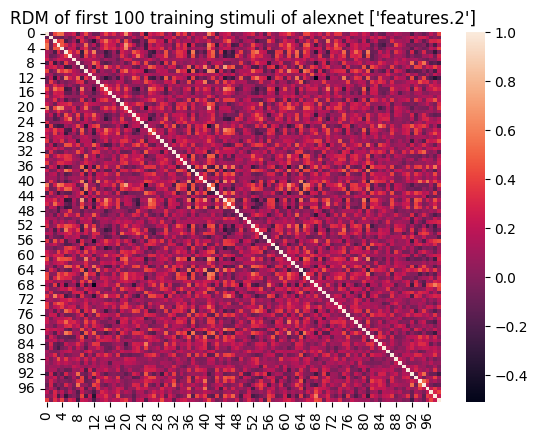

In [ ]:
# @title Plot DNN RDM
sns.heatmap(rdm_dnn_train[:plot_n_stimuli,:plot_n_stimuli])
plt.title(f"RDM of first {plot_n_stimuli} training stimuli of {modelname} {target_layers}")
plt.show()

## Compare RDMs

As the RDMs are symmetric along the diagonal, we only need either of the sides (we take the upper triangle). Otherwise, the comparison value we find will be higher than the true correlation. We then flatten this upper triangle to obtain a *representational dissimilarity vector* (RDV). This can conveniently be done using the `triu_indices` function from NumPy.





In [ ]:
# @title Helper function to vectorize a matrix
def triu_vector(rdm):
    """
    Function to extract the upper triangle from a matrix.
    """
    n_stimuli = rdm.shape[0]
    triangle = np.triu_indices(n_stimuli, k=1)
    rdv = rdm[triangle]

    return rdv

## Comparison methods
Now, all that's left is comparing how these representations of our stimulus images relate to one another. We can compare our RDVs by computing how similar they are using similarity metrics. There are various ways of doing so, depending on different facets of your data and research question. When deciding what similarity metric to use, you should take into account:

- **Variance in data scale:** Does the data underlying your RDM/Vs exist on very different scales? if so, do you need to take these differences in scale into account?
- **Linearity of relation:** Is it reasonable to expect a linear relationship between your representations?
- **Outlier leniency:** How to deal with outliers?
- **Interpretability of results:** Not all similarity metrics are as interpretable. Ideally your metric of choice exhibits a local optimal balance between complexity and interpretability.

However, the most common and stringent option is computing the cosine similarity between your RDVs. Other options include Pearson's correlation or Spearman's rank correlation without tie correction known as Spearman's $ρ_α$. [Source](https://rsatoolbox.readthedocs.io/en/latest/comparing.html)

---
####**Question:**
Come up with 2 research questions. One for which your comparisons are indifferent to variance in data scale, and one for which you should account for potential differences in data scale. Which similarity metric is best in each situation?

**YOUR ANSWER HERE**

####**Question:**
Try to implement the **cosine distance comparison**, and one of the **correlation** methods. For beginners we advise doing the Pearson's correlation, otherwise Spearman's $\rho_\alpha$ is more challenging. For an extra challenge, try to do this wihtout using any of the Sklearn or SciPy correlation functions. You can make use of the `triu_vector` helper function.

Cosine similarity is defined as:

$$
\text{similarity}(X, Y) = \frac{\sum_{i=1}^{n} X_i Y_i}{\sqrt{\sum_{i=1}^{n} X_i^2} \sqrt{\sum_{i=1}^{n} Y_i^2}}
$$

Where $X$ and $Y$ are the vectorized RDMs.

In [ ]:
def compare_cosine(rdm1, rdm2):
    """
    Takes two RDMs and computes the cosine similarity between the two.
    """
    # Your code here!
    rdv1 = triu_vector(drm1)
    rdv2 = triu_vector(drm2)

    covariance = np.sum(rdv1 * rdv2)

    std_dev1 = np.sqrt(np.sum(rdv1**2))
    std_dev2 = np.sqrt(np.sum(rdv2**2))

    correlations = covariance / (std_dev1 * std_dev2)

    return correlation

In [ ]:
# @title Click to see solution
def compare_cosine(rdm1, rdm2):
    """
    Takes two RDMs and computes the cosine similarity between the two.
    """
    rdv1 = triu_vector(rdm1)
    rdv2 = triu_vector(rdm2)

    covariance = np.sum(np.dot(rdv1,rdv2))

    std_dev1 = np.sqrt(np.sum(rdv1**2))
    std_dev2 = np.sqrt(np.sum(rdv2**2))

    correlations = covariance / np.dot(std_dev1, std_dev2)

    return correlations

Pearson's correlation is defined as:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$

Where $X$ and $Y$ are the vectorized RDMs.

In [ ]:
def compare_pearson(rdm1, rdm2):
    """
    Takes two RDMs and returns Pearson's correlation between the two.
    """
    # Your code here!
    rdv1 = triu_vector(rdm1)
    rdv2 = triu_vector(rdm2)

    rdv1 = rdv1 - np.mean(rdv1)
    rdv2 = rdv2 - np.mean(rdv2)

    covariance = np.sum(rdv1 * rdv2)

    std_dev1 = np.sqrt(np.sum(rdv1**2))
    std_dev2 = np.sqrt(np.sum(rdv2**2))

    correlations = covariance / (std_dev1 * std_dev2)

    return correlation

In [ ]:
# @title Click to see solution
def compare_pearson(rdm1, rdm2):
    """
    Takes two RDMs and returns Pearson's correlation between the two.
    """
    rdv1 = triu_vector(rdm1)
    rdv2 = triu_vector(rdm2)

    rdv1 = rdv1 - np.mean(rdv1)
    rdv2 = rdv2 - np.mean(rdv2)

    covariance = np.sum(rdv1 * rdv2)

    std_dev1 = np.sqrt(np.sum(rdv1**2))
    std_dev2 = np.sqrt(np.sum(rdv2**2))

    correlations = covariance / (std_dev1 * std_dev2)

    return correlations

Spearman's $\rho_\alpha$ is given by:

$$\frac{12}{n^3 - n}\sum_{i=1}^{n} (R_{X_i} - \bar{R}_X) (R_{Y_i} - \bar{R}_Y)$$

Where $R_{X_i}$ and $R_{Y_i}$ are the ranked vectorized RDMs.

In [ ]:
def compare_spearman_rho_alpha(rdm1, rdm2):
    """
    Takes two RDMs and computes Spearman's rho_alpha between the two.
    """
    # Your code here!
    rdv1 = triu_vector(rdm1)
    rdv2 = triu_vector(rdm2)

    # ranked_vectorized_rdm = np.argsort(np.argsort(vectorized_rdm))
    rdv1.sort()
    rdv2.sort()

    rdv1 = rdv1 - np.mean(rdv1)
    rdv2 = rdv2 - np.mean(rdv2)


    return correlation

In [ ]:
# @title Click to see solution
def compare_spearman_rho_alpha(rdm1, rdm2):
    """
    Takes two RDMs and computes Spearman's rho_alpha between the two.
    """
    rdv1 = triu_vector(rdm1)
    rdv2 = triu_vector(rdm2)

    rdv1 = rankdata(rdv1)
    rdv2 = rankdata(rdv2)

    rdv1 = rdv1 - np.mean(rdv1)
    rdv2 = rdv2 - np.mean(rdv2)

    n_stimuli = rdv1.shape[0]
    correlation = 12 * np.dot(rdv1, rdv2) / (n_stimuli ** 3 - n_stimuli)

    return correlation

In [ ]:
def compare_rdms(rdm1, rdm2, method="rho-alpha"):
    if method == 'cosine':
        sim = compare_cosine(rdm1, rdm2)
    elif method == 'pearson':
        sim = compare_pearson(rdm1, rdm2)
    elif method == 'rho-alpha':
        sim = compare_spearman_rho_alpha(rdm1, rdm2)
    else:
        raise ValueError('Unknown comparison method requested!')
    return sim

In [ ]:
# @title Choose comparison method and RDMs
method = "rho-alpha" # @param ["cosine", "pearson", "spearman", "rho-alpha"]
rdm1 = rdm_rh_train # @param ["rdm_lh_train", "rdm_rh_train"]
rdm2 = rdm_dnn_train # @param ["rdm_dnn_train"]

Now we can use the `compare_rdms` function to compare 2 RDMs!

In [ ]:
correlation = compare_rdms(rdm1, rdm2, method)
print(f"The {method} correlation is {correlation}")

The rho-alpha correlation is 0.07068563109079858


In [ ]:
# @title Helper functions to get ROI and DNN RDMs
def get_roi_rdms(subj, roi):

    subj_dir = os.path.join(fmri_dir, f'subj{subj:02d}')

    lh_fmri = np.load(os.path.join(subj_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(subj_dir, 'rh_training_fmri.npy'))

    lh_fmri_train = lh_fmri[idxs_train]
    lh_fmri_test = lh_fmri[idxs_test]
    rh_fmri_train = rh_fmri[idxs_train]
    rh_fmri_test = rh_fmri[idxs_test]

    # Get subject ROI data
    lh_mask = get_roi_mask(roi, 'lh', subj)[0][:lh_fmri.shape[1]]
    lh_roi_train = lh_fmri_train[:,np.where(lh_mask)[0]]
    lh_roi_test = lh_fmri_test[:,np.where(lh_mask)[0]]

    rh_mask = get_roi_mask(roi, 'rh', subj)[0][:lh_fmri.shape[1]]
    rh_roi_train = rh_fmri_train[:,np.where(rh_mask)[0]]
    rh_roi_test = rh_fmri_test[:,np.where(rh_mask)[0]]

    # Create ROI RDMs
    rdm_lh_roi_train = create_rdm(lh_roi_train)
    rdm_lh_roi_test = create_rdm(lh_roi_test)
    rdm_rh_roi_train = create_rdm(rh_roi_train)
    rdm_rh_roi_test = create_rdm(rh_roi_test)

    return rdm_lh_roi_train, rdm_lh_roi_test, rdm_rh_roi_train, rdm_rh_roi_test

def get_dnn_rdms(model, layers):
    feat_extractor = FeatureExtractor(model, device=device, target_layers=layers)

    _, features_train_dict = extract_features(feat_extractor, train_imgs_dataloader)
    _, features_test_dict = extract_features(feat_extractor, test_imgs_dataloader)

    rdm_dnn_train = np.zeros((len(idxs_train), len(idxs_train), len(layers)))
    rdm_dnn_test = np.zeros((len(idxs_test), len(idxs_test), len(layers)))

    for i, layer in enumerate(layers):
        rdm_dnn_train[:,:,i] = create_rdm(features_train_dict[layer])
        rdm_dnn_test[:,:,i] = create_rdm(features_test_dict[layer])

    return rdm_dnn_train, rdm_dnn_test

In [ ]:
lh_train, lh_test, rh_train, rh_test = get_roi_rdms(1, "ventral")

In [ ]:
compare_rdms(lh_train, rh_train, method="rho-alpha")

0.7301114253890533

## Compare multiple layers and ROIs

Now it is time to explore the true flexibility of RSA. We can make comparisons using different DNN layers and ROIs. As long as the RDMs are of the same shape, virtually any modality could be used in the comparison!

We will here choose one model and create and RDM for multiple layers of this model. We will then correlate each of these RDMs to both the "early" and "ventral" ROIs, similar to the first tutorial.

Feel free to experiment with different DNNs, layers and ROIs.

In [ ]:
# @title Choose model and layers
modelname = 'alexnet' #@param ['alexnet', 'resnet50', 'clip'] {allow-input: true}
target_layers = ["features.2", "features.5", "features.7", "features.9", "features.12"] #@param {type: 'string'}

In [ ]:
rdm_dnn_train, rdm_dnn_test = get_dnn_rdms(modelname, target_layers)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# @title Helper functions to plot RSA results
def barplot(ax, data, x, y, hue, title=None, noise_ceilings=None, ylim=None):
    """
    Function to show a barplot with an additional (optional) noise ceiling.
    """
    sns.barplot(ax=ax, x=x, hue=hue, y=y, errorbar=('ci', 68), data=data)

    if ylim is not None:
        ax.set_ylim(ylim)

    if noise_ceilings is not None:
        upper_lim = max([nc[1] for nc in noise_ceilings]) + 0.1
        ax.set_ylim(0, upper_lim)

        bar_width = [b.get_width() for b in ax.patches if b.get_width() != 0][0]

        noiseceil_idx = 0

        for i, roi in enumerate(data['roi'].unique()):

            nc1 = noise_ceilings[noiseceil_idx]
            left1 = i - bar_width
            bottom1 = nc1[0]

            ax.add_patch(plt.Rectangle((left1, bottom1), bar_width-0.01, nc1[1] - nc1[0], color='grey', alpha=0.3))

            nc2 = noise_ceilings[noiseceil_idx + 1]
            left2 = i
            bottom2 = nc2[0]

            ax.add_patch(plt.Rectangle((left2, bottom2), bar_width-0.01, nc1[1] - nc1[0], color='grey', alpha=0.3))

            noiseceil_idx += 2

    ax.set_title(title)

def plot_all_layers(data, x='roi', y='mean_corr', hue='hemisphere', noise_ceilings=None, n_cols=3):
    """
    Function to create barplots for each layer in a single figure with a common y-axis.
    """
    layers = data['layer'].unique()
    n_layers = len(layers)
    n_rows = (n_layers + n_cols - 1) // n_cols  # Calculate the number of rows needed

    # Determine the global y-axis limits
    global_min = data[y].min()
    global_max = data[y].max()
    ylim = (global_min, global_max)

    # Create a grid of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True)
    axes = axes.flatten()  # Flatten in case we have more than 1 row

    for i, layer in enumerate(layers):
        ax = axes[i]
        layer_data = data[data['layer'] == layer]
        layer_title = f'Layer: {layer}'

        barplot(ax, layer_data, x=x, y=y, hue=hue, title=layer_title, noise_ceilings=noise_ceilings, ylim=ylim)

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
# @title Choose ROIs
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

In [ ]:
rsa_df = []

for subj in tqdm(range(1, 9)):
    roi_1_lh_train, _, roi_1_rh_train, _ = get_roi_rdms(subj, roi_1)
    roi_2_lh_train, _, roi_2_rh_train, _ = get_roi_rdms(subj, roi_2)

    for layer in range(5):
        rsa_df.append({
            'subject': f'subj-{subj:02d}',
            'layer': f'{target_layers[layer]}',
            f'mean_corr': compare_rdms(rdm_dnn_train[:,:,layer], roi_1_lh_train),
            'hemisphere': 'left',
            'roi': roi_1
        })
        rsa_df.append({
            'subject': f'subj-{subj:02d}',
            'layer': f'{target_layers[layer]}',
            f'mean_corr': compare_rdms(rdm_dnn_train[:,:,layer], roi_1_rh_train),
            'hemisphere': 'right',
            'roi': roi_1
        })
        rsa_df.append({
            'subject': f'subj-{subj:02d}',
            'layer': f'{target_layers[layer]}',
            f'mean_corr': compare_rdms(rdm_dnn_train[:,:,layer], roi_2_lh_train),
            'hemisphere': 'left',
            'roi': roi_2
        })
        rsa_df.append({
            'subject': f'subj-{subj:02d}',
            'layer': f'{target_layers[layer]}',
            f'mean_corr': compare_rdms(rdm_dnn_train[:,:,layer], roi_2_rh_train),
            'hemisphere': 'right',
            'roi': roi_2
        })

rsa_df = pd.DataFrame(rsa_df)

  0%|          | 0/8 [00:00<?, ?it/s]

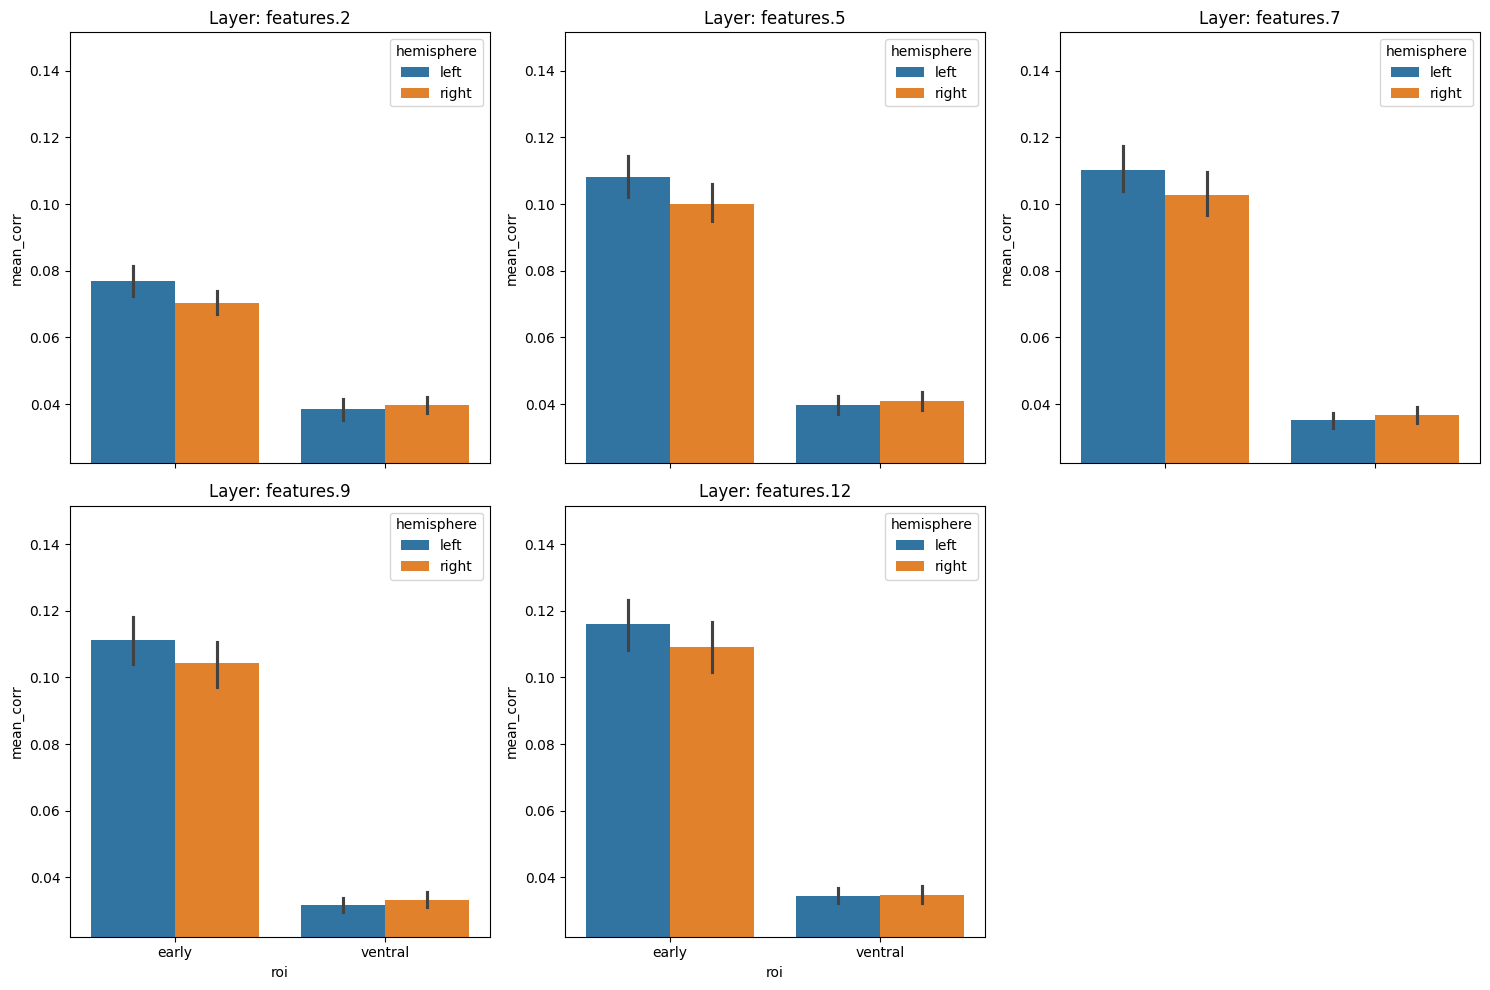

In [ ]:
# @title Plot results
plot_all_layers(rsa_df)

## Noise ceiling

Similar to yesterday's tutorial, we will calculate the noise ceiling across participants [source](https://www.johancarlin.com/understanding-noise-ceiling-metrics-rsa-compared-to-spearman-brown.html). For RSA, this is relatively straightforward, as we can use the subject RDMs in place of the activations. Recall the explanation from Tutorial 1:

- We estimate a *lower noise ceiling* by correlating the activations of a held-out subject to the mean activations of the remaining $N-1$ subjects. This is an under-estimate of the true maximum correlation.

- And we estimate an *upper noise ceiling* by correlating the activations of each subject to the mean activations of all subjects, *including* that subject. This is an over-estimate of the true maximum correlation.

We estimate both of these across all participants, and take the average. The true noise ceiling will lie somewhere in between these two extremes.

In [ ]:
def lower_noise_ceiling(rdms):
    """Returns the lower noise ceiling given a list of subject RDMS."""
    num_subjs = len(rdms)
    lnc = 0.0

    for i in range(num_subjs):
        subj_rdm = rdms[i]
        subj_rdm = subj_rdm[np.triu_indices(subj_rdm.shape[0],k=1)]
        rdm_subj_removed = np.delete(rdms, i, axis=0)

        mean_subj_rdm = np.mean(rdm_subj_removed, axis=0)
        mean_subj_rdm = mean_subj_rdm[np.triu_indices(mean_subj_rdm.shape[0],k=1)]
        lnc += pearsonr(subj_rdm, mean_subj_rdm)[0]

    lnc = lnc / num_subjs
    return lnc

In [ ]:
def upper_noise_ceiling(rdms):
    """Returns the upper noise ceiling given a list of subject RDMS."""
    num_subjs = len(rdms)
    unc = 0.0
    mean_subj_rdm = np.mean(rdms, axis=0)
    mean_subj_rdm = mean_subj_rdm[np.triu_indices(mean_subj_rdm.shape[0],k=1)]

    for i in range(num_subjs):
        subj_rdm = rdms[i]
        subj_rdm = subj_rdm[np.triu_indices(subj_rdm.shape[0],k=1)]
        unc += pearsonr(subj_rdm, mean_subj_rdm)[0]

    unc = unc / num_subjs
    return unc

In [ ]:
def compute_noise_ceiling(roi, hemi):
    """Compute the noise ceiling for a ROI and hemisphere."""
    all_rdms = []
    for subj in range(1, 9):
        if hemi == "lh":
            rdm, _, _, _ = get_roi_rdms(subj, roi)
        elif hemi == "rh":
            _, _, rdm, _ = get_roi_rdms(subj, roi)

        all_rdms.append(rdm)

    lower = lower_noise_ceiling(all_rdms)
    upper = upper_noise_ceiling(all_rdms)

    return (lower, upper)

In [ ]:
# @title Compute the noise ceiling for each ROI and hemisphere
all_noiseceilings = []
for roi in [roi_1, roi_2]:
    for hemi in ['lh', 'rh']:
        this_nc = compute_noise_ceiling(roi, hemi)
        print(roi, hemi, this_nc)
        all_noiseceilings.append(this_nc)

early lh (0.4729958815445339, 0.6211538081481408)
early rh (0.46165515099800253, 0.6137862917959844)
ventral lh (0.6497529687037576, 0.7369937051604037)
ventral rh (0.736977081597378, 0.8024924980024432)


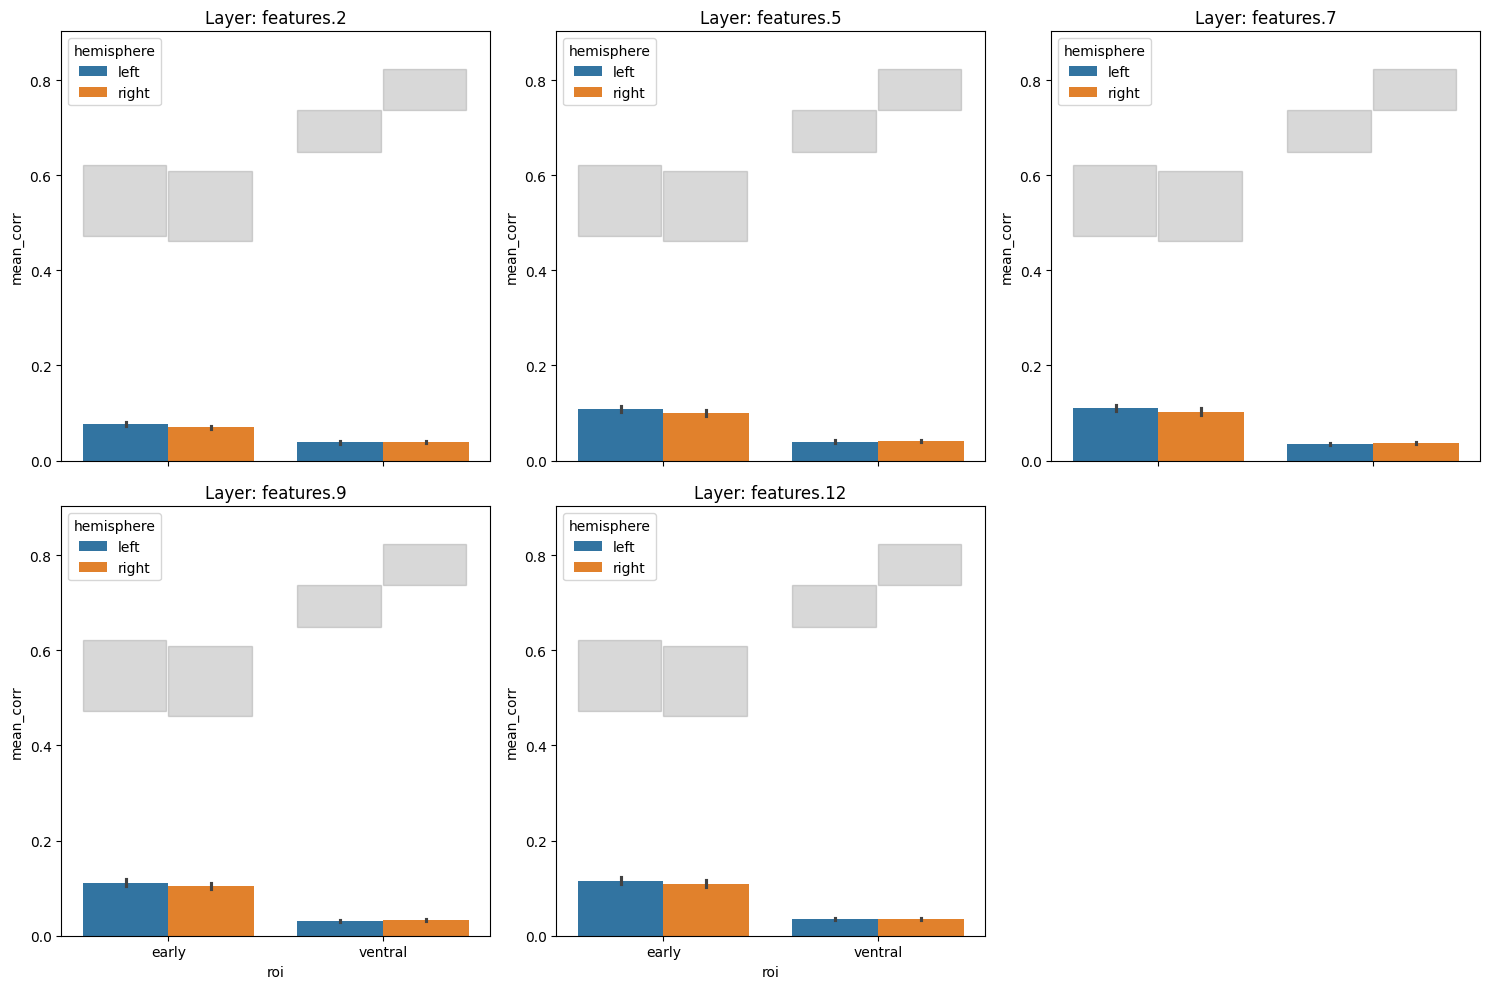

In [ ]:
# @title Plot results with noise ceilings
plot_all_layers(rsa_df, noise_ceilings=all_noiseceilings)

---
####**Question:**
What conlusions can we draw from these results? What might be possibilities to improve the alignment?

This model is not probabl suitable for ventral streams

# Reweighted RSA

Classical RSA gives equal value to all features. This might lead to underestimating the actual correlation between the neural data and the DNN activations. One way to improve this alignment is to do a reweighting of the features. [This paper](https://www.sciencedirect.com/science/article/pii/S105381192200413X) provides an in depth explanation of reweighted RSA and its possibilities.

We can reweight the features using a regression, a common type of regression to use for this is a ridge regression (there it is again!) with cross-validation for the parameters.
To remind you what the ridge optimization problem looks like:

$$w = \arg\min_{w}||Xw - y||^2+\alpha||w||^2$$

We provide a search space for the `alpha` hyperparameter, but feel free to adjust it!

In [ ]:
# @title Helper functions for the ridge regression
def get_preds_from_RDM(rdm):
    '''
    This function takes in an RDM and returns a feature matrix
    The RDM is in a shape of (n_stimuli, n_stimuli, n_layers)
    '''
    # Get shape of flattened upper triangle
    rdv = triu_vector(rdm[:,:,0])

    features = np.zeros((rdv.shape[0], rdm.shape[2])) # Length of flattened upper triangle x number of layers

    # Fill in predictors
    for l in range(rdm.shape[2]):
        features[:,l] = triu_vector(rdm[:,:,l])

    # Standardization step
    scaler = StandardScaler()
    features_s = np.zeros((features.shape))
    for l in range(features.shape[1]):
        feats_s = scaler.fit_transform(features[:,l].reshape(-1,1))
        features_s[:,l] = feats_s[:,0]

    return features_s

def fit_RIDGE(subj_rdm, dnn_rdm):
    """Fit a ridge regression to the RDMs"""
    scaler = StandardScaler()
    alphas = np.logspace(-1, 5, 7)
    all_betas = np.zeros(dnn_rdm.shape[1])
    rdv = triu_vector(subj_rdm)
    rdv = scaler.fit_transform(rdv.reshape(-1,1))
    model = RidgeCV(alphas=alphas, scoring='explained_variance').fit(dnn_rdm, rdv)
    all_betas = model.coef_

    return all_betas

def reweighted_rsa(dnn_train, dnn_test, subj_train, subj_test):

    feats = get_preds_from_RDM(dnn_train)

    # Regression betas
    betas = fit_RIDGE(subj_train, feats)[0]

    scaler=StandardScaler()
    subj_test_rdv = triu_vector(subj_test)
    subj_test_rdv = scaler.fit_transform(subj_test_rdv.reshape(-1,1))

    pred_rw = get_preds_from_RDM(dnn_test) @ betas

    corr = pearsonr(pred_rw.flatten(), subj_test_rdv.flatten())[0]

    return corr

In [ ]:
# @title Choose ROIs
roi_1 = 'early' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}
roi_2 = 'ventral' #@param ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal"] {allow-input: true}

rrsa_df = []

for subj in tqdm(range(1, 9)):
    roi_1_lh_train, roi_1_lh_test, roi_1_rh_train, roi_1_rh_test = get_roi_rdms(subj, roi_1)
    roi_2_lh_train, roi_2_lh_test, roi_2_rh_train, roi_2_rh_test = get_roi_rdms(subj, roi_2)

    lh_rw1 = reweighted_rsa(rdm_dnn_train, rdm_dnn_test, roi_1_lh_train, roi_1_lh_test)
    rh_rw1 = reweighted_rsa(rdm_dnn_train, rdm_dnn_test, roi_1_rh_train, roi_1_rh_test)
    lh_rw2 = reweighted_rsa(rdm_dnn_train, rdm_dnn_test, roi_2_lh_train, roi_2_lh_test)
    rh_rw2 = reweighted_rsa(rdm_dnn_train, rdm_dnn_test, roi_2_rh_train, roi_2_rh_test)

    rrsa_df.append({
        'subject': f'subj-{subj:02d}',
        'layer': 'reweighted',
        f'mean_corr': lh_rw1,
        'hemisphere': 'left',
        'roi': roi_1
    })
    rrsa_df.append({
        'subject': f'subj-{subj:02d}',
        'layer': 'reweighted',
        f'mean_corr': rh_rw1,
        'hemisphere': 'right',
        'roi': roi_1
    })
    rrsa_df.append({
        'subject': f'subj-{subj:02d}',
        'layer': 'reweighted',
        f'mean_corr': lh_rw2,
        'hemisphere': 'left',
        'roi': roi_2
    })
    rrsa_df.append({
        'subject': f'subj-{subj:02d}',
        'layer': 'reweighted',
        f'mean_corr': rh_rw2,
        'hemisphere': 'right',
        'roi': roi_2
    })

rrsa_df = pd.DataFrame(rrsa_df)


  0%|          | 0/8 [00:00<?, ?it/s]

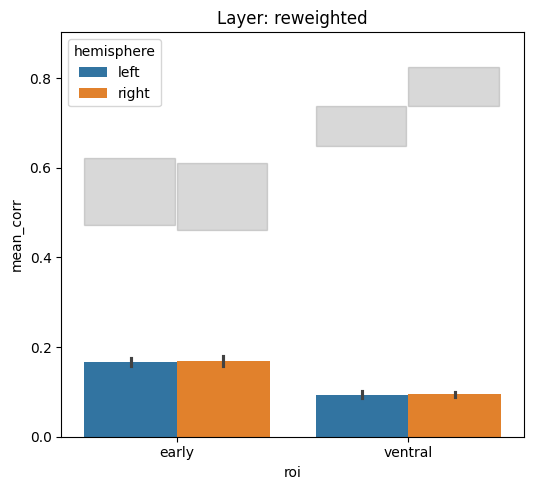

In [ ]:
# @title Plot results with noise ceilings
plot_all_layers(rrsa_df, noise_ceilings=all_noiseceilings)

---
####**Question:**
Can you see any improvement compared to the classical RSA? How could this be explained?

Without noise ceiling changing, the mean_corr has increased. More variables explained.

# Multidimensional scaling

With *multidimensional scaling* (MDS) we can force our RDMs to populate a smaller space (usually two dimensions). This way, we can visualize whether representations of similar images are actually closer together, and thus more similarly represented. This can help us explore te data, potentially revealing patterns we might not have thought of.

To not make it to crowded, we use the test set for the visualization. Feel free to change the data used!

Although the COCO images themselves are unlabeled, the segmented object in the images are categorized. We can use these categories and supercategories to filter the images on whether they contain an object or not.

In [ ]:
# @title Get object label dataframe
df = pd.read_csv(main_dir + "/additional_data/stimulus_data.csv")
df['nsd_id'] = df['image_name'].str.extract(r'(nsd\d+)')
shared_ids = [id.split('_')[-1].split('.')[0].replace('-', '') for id in img_list]
shared_ids = [f"nsd{int(id[3:]) + 1:05d}" for id in shared_ids]
df = df[df['nsd_id'].isin(shared_ids)]
df = df.sort_values(by='nsd_id').reset_index()
df = df.loc[sorted(idxs_test)].reset_index()

In [ ]:
df.head(3)

,level_0,index,image_id,image_name,image_path,coco_id,coco_supercategs,coco_categs,coco_areas,coco_captions,nsd_id
0,2,347,coco_262414,shared0003_nsd03050.png,/content/DeepNSD/neural_data/natural_scenes_de...,262414,"['person', 'sports']","['person', 'surfboard']","[4811.3480500000005, 952.6506500000002]",['A person in a wetsuit surfing on a turquoise...,nsd03050
1,17,634,coco_264735,shared0018_nsd03810.png,/content/DeepNSD/neural_data/natural_scenes_de...,264735,"['animal', 'animal', 'animal', 'animal', 'anim...","['cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'co...","[2627.1602500000004, 1421.0372000000002, 460.1...","['A herd of cattle grazing on a grassy hill.',...",nsd03810
2,39,858,coco_268659,shared0042_nsd05107.png,/content/DeepNSD/neural_data/natural_scenes_de...,268659,['animal'],['giraffe'],[31380.96924999999],['A large giraffe walking across a dirt lot ne...,nsd05107


In [ ]:
# @title Select super category
super_category = 'vehicle' # @param ['person', 'sports', 'animal', 'vehicle', 'kitchen', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'outdoor', 'accessory']
object_ids = df.index[df['coco_supercategs'].apply(lambda x: super_category in x)].tolist()

Shape of mds_R: (87, 2)


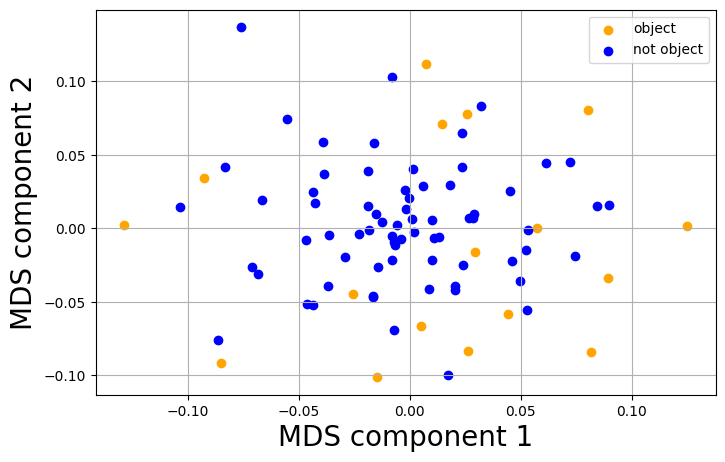

In [ ]:
# @title Plot MDS
mds = MDS(dissimilarity='precomputed', n_components=2, normalized_stress='auto')
mds_R = mds.fit_transform(rdm_dnn_test[:,:,0])
print("Shape of mds_R:", mds_R.shape)

idxs = np.argsort(np.array(shared_ids)[idxs_test])
is_object = np.array([i in object_ids f or i in range(len(mds_R))])[np.argsort(idxs)]


plt.figure(figsize=(8, 5))
plt.grid()
plt.scatter(mds_R[is_object, 0], mds_R[is_object, 1], c='orange', label='object')
plt.scatter(mds_R[~is_object, 0], mds_R[~is_object, 1], c='blue', label='not object')
plt.legend()
plt.xlabel('MDS component 1', fontsize=20)
plt.ylabel('MDS component 2', fontsize=20)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

plt.show()

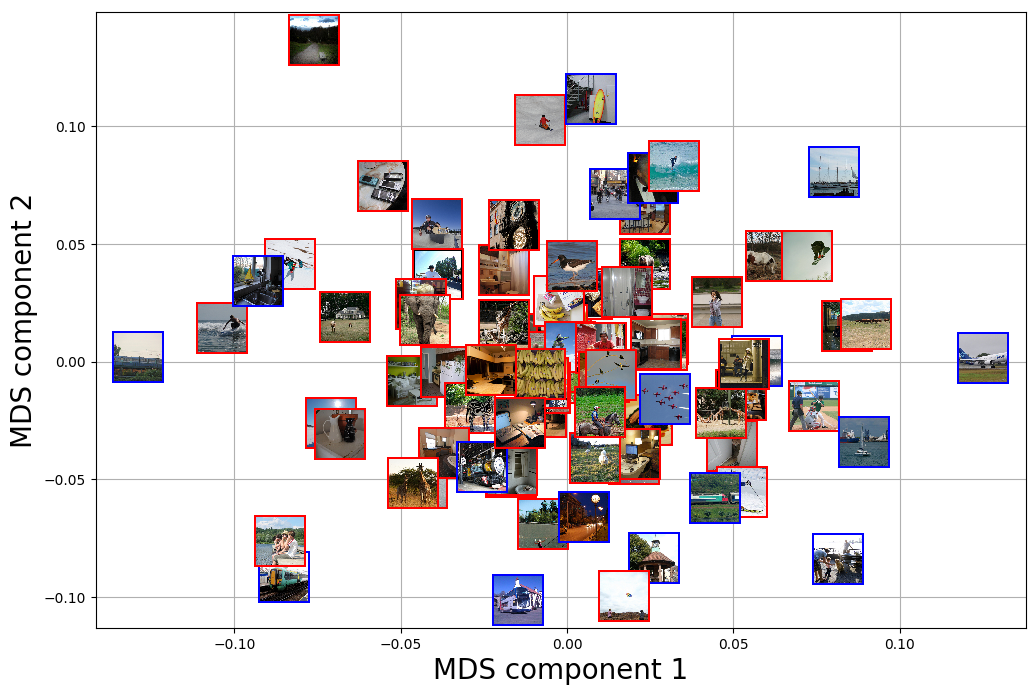

In [ ]:
# @title Plot MDS with images
from PIL import ImageOps
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid()

images = [img_list[i] for i in idxs_test]
images = [Image.open(os.path.join(stim_dir, img_name)) for img_name in images]

# Function to create an AnnotationBbox with an image and a colored border
def image_annotation(ax, xy, image, zoom=0.1, border_color='red'):
    # Add a border to the image
    border_size = max(1, int(max(image.size) * 0.05))  # Border is 5% of the image size
    image_with_border = ImageOps.expand(image, border=border_size, fill=border_color)

    imagebox = OffsetImage(image_with_border, zoom=zoom)
    ab = AnnotationBbox(imagebox, xy, frameon=False, pad=0.3)
    ax.add_artist(ab)

# Add images to the plot with a colored border
for i in range(len(mds_R)):
    xy = (mds_R[i, 0], mds_R[i, 1])
    border_color = 'blue' if is_object[i] else 'red'
    image_annotation(ax, xy, images[i], zoom=0.08 if is_object[i] else 0.08, border_color=border_color)

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel('MDS component 1', fontsize=20)
plt.ylabel('MDS component 2', fontsize=20)
plt.show()

---
####**Question:**
Looking at our MDS results, we don't see a very distinct pattern between the two image categories used. Provide **two** reasons why this might be the case in our current analysis.

**YOUR ANSWER HERE**

___
The end of part 1
___

# Tutorial Day 2 - SPoSE

by Giacomo Aldegheri

\
\
In this tutorial, we will look at **SPoSE** (Sparse Positive Object Similarity Embeddings) a model proposed by Martin Hebart and colleagues in a [2020 paper](https://www.nature.com/articles/s41562-020-00951-3) and then in a [follow-up paper](https://elifesciences.org/articles/82580) to estimate the dimensions underlying human judgments of image similarities. What does that mean?

They ran a large-scale online behavioral study, in which they simply showed, on each trial, 3 images, and asked participants to indicate which was the odd one out (the image most dissimilar to the others):

<img src='https://drive.google.com/uc?id=1zONI4kRZmsP0jlO-tNgPYy46EhVsHXVL' width=400>

They did this for 1854 object concepts (from the [THINGS database](https://things-initiative.org/)) and 1.46 million trials.

Using this data, they tried to understand the dimensions underlying subjects' similarity judgments. They used the following procedure:

\
<img src='https://drive.google.com/uc?id=1zPHHATd117y1YWGSs4FbRoD9FI5TWGjh' width=750>

\
In essence, they pre-specified a number of embedding dimensions (e.g. 40) and created a simple linear model with a `1854 x 40` (n. concepts x n. dimensions) weight matrix. They fed each concept as a 1854-dimensional one-hot vector to the model, and transformed it into a 40-dimensional embedding.

The embeddings were extracted for each of the three items in a triplet (**step 1** in the figure above), and their pairwise similarity was computed with a dot product (**step 2**). These dot products were turned into choice probabilities using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function) (**step 3**), and the model's choice (pair with the highest probability) was compared to a human subject's choice (**step 4**).

The idea is that among the three pairs, the highest probability (pairwise similarity) should be assigned to the pair that does *not* include the odd-one-out. For example, if from the triplet `glass, bottle, car` I judge the car to be the odd-one-out, the model should predict the pair `glass, bottle` to have a higher similarity than `glass, car` and `bottle, car`. The distance ([cross-entropy loss](https://en.wikipedia.org/wiki/Cross-entropy)) between the model's choice and the correct choice was then [backpropagated](https://en.wikipedia.org/wiki/Backpropagation) to the weights, making them increasingly informative about subjects' judgments.

They also put two additional constraints on the weights:

- They had to be **positive**: the intuition is that each weight should reflect the presence, or absence, of a given feature. E.g. an animal can be more or less furry, but it can't be negative furry.

- They had to be **sparse**: (for any given input, most features' activations should be 0) when a lot of features are present for each object, they are usually not very interpretable. Only a few features should be active for any given object.

Both of these constraints were informed using special loss functions, as we will see below.

The resulting features turn out to reflect interpretable concepts, that reflect the dimensions along which people's internal representations of objects are organized.

\
With all that in mind, time to dive into the code! This tutorial closely follows the [official implementation](https://github.com/ViCCo-Group/SPoSE).



## Import libraries

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import os
import re
from tqdm.notebook import tqdm
from typing import Tuple
import random

rand_seed = 123
random.seed(rand_seed)
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## Set device

If possible, use the GPU for much faster computation!

In [104]:
device = 'cpu' # @param ['cuda', 'cpu']
if device == 'cuda':
  assert torch.cuda.is_available(), 'GPU not available! Please select a GPU runtime or use CPU.'
device = torch.device(device)

## Mount Google Drive

You should have already added a shortcut to the data folder in your Google Drive during yesterday's tutorial. If not, this is how you do it:

<img src='https://drive.google.com/uc?id=15TNjV__sWCcnBRlxbXNbJfpidx-C6nrk' width=500>

Go to the [folder](https://drive.google.com/drive/folders/1AjDOejWLjfXGkr-hK07SZJ_4ni1nypjw?usp=sharing), right click on its name, and select `Organize -> Add shortcut`. It will add a shortcut to your own Google Drive without the need to copy any data or occupy any storage.

In [115]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# data_dir = '/content/drive/MyDrive/UvA_encodingtutorial/SPoSE/triplet_dataset/'
data_dir = '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/UvA_encodingtutorial/SPoSE/triplet_dataset/'

Mounted at /content/drive/


## Specify directory to save trained model parameters

After we have trained the model (as well as during training, to see how the weights evolve) we want to save the model's weights.

This should be on your own Google Drive, not in the shared folder, where you don't have writing permissions.

In [116]:
log_dir = 'SPoSE_weights' #@param {type: 'string'}
log_dir = f'/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/{log_dir}/'
if not os.path.isdir(log_dir):
  os.makedirs(log_dir)

In [119]:
# @title Utility functions

def load_triplets(partition:str, data_dir=data_dir):
  if partition == 'train':
    fname = 'trainset.txt'
    n_items = 500000
  elif partition == 'val':
    fname = 'validationset.txt'
    n_items = 20000
  elif partition == 'test':
    fname = 'testset1.txt'
    n_items = 10000

  triplets = np.loadtxt(os.path.join(data_dir, fname))

  return torch.from_numpy(triplets[:n_items]).type(torch.LongTensor)

def accuracy_(probas:np.ndarray) -> float:
    choices = np.where(probas.mean(axis=1) == probas.max(axis=1), -1, np.argmax(probas, axis=1))
    acc = np.where(choices == 0, 1, 0).mean()
    return acc

def choice_accuracy(anchor:torch.Tensor, positive:torch.Tensor, negative:torch.Tensor) -> float:
    similarities  = compute_similarities(anchor, positive, negative)
    probas = F.softmax(torch.stack(similarities, dim=-1), dim=1).detach().cpu().numpy()
    return accuracy_(probas)

def filter_nonneg(W, threshold=0.1):
  W = W*(W>threshold)
  return W

## Dataset

Here, to speed up computations, we will only use a subset of the available. Specifically, this dataset contains 4.12M triplets, but we will only use 500K for training. It's less than 1/8 of the data, but we will see that it works quite well! For validation, we will use 20K.

In [120]:
train_triplets = load_triplets('train')
val_triplets = load_triplets('val')

print('Number of training samples:', len(train_triplets))
print('Number of validation samples:', len(val_triplets))

Number of training samples: 500000
Number of validation samples: 20000


The data contains 1854 concepts, as we can verify:

In [121]:
n_items = len(torch.unique(train_triplets))
print('N. unique concepts:', n_items)

N. unique concepts: 1854


Let's create a dataset to feed the triplets to our model. First, the unique concept IDs need to be coded as one-hot vectors (1854-dimensional, with 1 for the current concept's entry and 0 elsewhere).

In [122]:
def encode_as_onehot(I:torch.Tensor, triplets:torch.Tensor) -> torch.Tensor:
    """encode item triplets as one-hot-vectors"""
    return I[triplets.flatten(), :]


class TripletDataset(Dataset):

    def __init__(self, n_items:int, dataset:torch.Tensor):
        self.I = torch.eye(n_items)
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx:int) -> torch.Tensor:
        sample = encode_as_onehot(self.I, self.dataset[idx])
        return sample

## Model

Finally, time to code the actual model! As you can see, it's really simple. Just a single linear layer (only weights, no biases), with the number of concepts as input size and the number of embedding dimensions as output size.

**EXERCISE:** fill in the code for the single linear layer in the model.

In [124]:
class SPoSE(nn.Module):

    def __init__(
                self,
                in_size:int,
                out_size:int,
                init_weights:bool=True,
                ):
        super(SPoSE, self).__init__()
        self.in_size = in_size
        self.out_size = out_size
        # YOUR CODE HERE
        self.fc = nn.Linear(in_size, out_size)

        if init_weights:
            self._initialize_weights()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.fc(x)

    def _initialize_weights(self) -> None:
        mean, std = .1, .01
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(mean, std)

## Loss functions

And now one of the most important ingredients: the loss functions. First we code the two regularizers: the L1 regularization to enforce sparsity, and the positivity penalty to enforce positive weights.

- For **sparsity**, we use the [L1 loss](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261): $\sum_{i=1}^n|\textbf{W}_i|$ for each weight $\textbf{W}_i$.

- For **positivity**, we use the sum of all weights less than 0 as a loss term: $\sum_{i=1}^{n}\operatorname{ReLU}(-\textbf{W}_i)$ for each weight $\textbf{W}_i$.

\
**EXERCISE:** fill in the code for the positivity loss.

In [ ]:
def l1_regularization(model, device=device) -> torch.Tensor:
    l1_reg = torch.tensor(0., requires_grad=True)
    for n, p in model.named_parameters():
        if re.search(r'weight', n):
            l1_reg = l1_reg + torch.norm(p, 1)
    return l1_reg.to(device)

def pos_penalty(model) -> torch.Tensor:
  W = model.fc.weight
  # YOUR CODE HERE:
  #return ... # positivity constraint to enforce non-negative values in embedding matrix

Now, we code our main loss function, `trinomial_loss`.

It's based on the [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy) loss:

$$
H(p, q) = -\sum_{x \in \mathcal{X}}p(x)\log{q(x)}
$$

Where $p$ and $q$ are two probability distributions, corresponding to the ground-truth distribution and the model's outputs.

Basically, it makes sure the similarities between the triplets correspond to the choices in the odd-one-out task.

First, we need to compute the similarities between the embeddings (using the dot product).

Then, since in the dataset the chosen pair (that doesn't include the odd-one-out) is always the first in the triplet, we just need to ensure that the model's estimated choice probability/similarity for the first pair is always the highest.

**EXERCISE:** implement the dot product computation for the three pairs: `pos_sim` (anchor, positive), `neg_sim` (anchor, negative) and `neg_sim_2` (positive, negative)

In [ ]:
def compute_similarities(anchor:torch.Tensor, positive:torch.Tensor, negative:torch.Tensor) -> Tuple:
    # YOUR CODE HERE
    # pos_sim = ...
    # neg_sim = ...
    # neg_sim_2 = ...

    return pos_sim, neg_sim, neg_sim_2

def weighted_softmax(sims: tuple, t:float) -> torch.Tensor:
  return torch.exp(sims[0] / t) / torch.sum(torch.stack([torch.exp(sim / t) for sim in sims]), dim=0)

def cross_entropy_loss(sims:tuple, t:float) -> torch.Tensor:
    return torch.mean(-torch.log(weighted_softmax(sims, t)))

def trinomial_loss(anchor:torch.Tensor, positive:torch.Tensor, negative:torch.Tensor, t:float) -> torch.Tensor:
  sims = compute_similarities(anchor, positive, negative)
  return cross_entropy_loss(sims, t)

## Hyperparameters

Now we're all set! We just need to set a few hyperparameters:

- `lmbda`: this is the weight of the l1-regularization (we can't use the name `lambda` as it's a Python keyword 😁)
- `temperature`: the temperature for the softmax function.
- `lr`: the learning rate.
- `batch_size`: the batch size for training.
- `embed_dim`: the embedding's dimensionality.
- `n_epochs`: number of training epochs.

In [ ]:
lmbda = 0.02
temperature = 1.
lr = 0.001
batch_size = 100
embed_dim = 40
n_epochs = 16

Let's define our model, datasets, dataloaders and the optimizer.

In [ ]:
model = SPoSE(in_size=n_items, out_size=embed_dim, init_weights=True)
model = model.to(device)

# Training/validation datasets and dataloaders:
trainset = TripletDataset(n_items, train_triplets)
validationset = TripletDataset(n_items, val_triplets)
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset=validationset, batch_size=batch_size, shuffle=False)

# Optimizer (Adam with default settings)
optim = Adam(model.parameters(), lr=lr)

## Training loop

Ok, now it's time to train the model! With a GPU backend, it should take around 10 minutes.

In [ ]:
crossentropies = []
complexity_losses = []
train_losses = []
train_accs = []

for epoch in tqdm(range(n_epochs)):

  model.train()

  # To keep track of the losses
  batch_crossentropies = torch.zeros(len(trainloader))
  batch_complosses = torch.zeros(len(trainloader))
  batch_losses_train = torch.zeros(len(trainloader))
  batch_accs_train = torch.zeros(len(trainloader))

  for i, batch in enumerate(trainloader):
    optim.zero_grad()
    batch = batch.to(device)
    logits = model(batch)

    # separate the three embeddings:
    anchor, positive, negative = torch.unbind(logits, dim=1)

    c_entropy = trinomial_loss(anchor, positive, negative, temperature)
    l1_pen = (lmbda/n_items) * l1_regularization(model, device=device)
    pos_pen = pos_penalty(model)

    # Sum everything into one big loss:
    loss = c_entropy + 0.01 * pos_pen + l1_pen
    loss.backward()
    optim.step()

    batch_losses_train[i] += loss.item()
    batch_crossentropies[i] += c_entropy.item()
    batch_complosses[i] += l1_pen.item()
    batch_accs_train[i] += choice_accuracy(anchor, positive, negative)

  avg_crossentropy = torch.mean(batch_crossentropies).item()
  avg_comploss = torch.mean(batch_complosses).item()
  avg_train_loss = torch.mean(batch_losses_train).item()
  avg_train_acc = torch.mean(batch_accs_train).item()


  ####################################
  # Validation
  ####################################

  val_accs = torch.zeros(len(valloader))
  val_losses = torch.zeros(len(valloader))

  model.eval()

  with torch.no_grad():
    for i, batch in enumerate(valloader):

      batch = batch.to(device)
      logits = model(batch)
      anchor, positive, negative = torch.unbind(logits, dim=1)

      val_loss = trinomial_loss(anchor, positive, negative, temperature)
      val_acc = choice_accuracy(anchor, positive, negative)

      val_losses[i] += val_loss.item()
      val_accs[i] += val_acc.item()

  avg_val_loss = torch.mean(val_losses).item()
  avg_val_acc = torch.mean(val_accs).item()


  print('\n==========================================================')
  print(f'Epoch: {epoch+1}, Train acc: {avg_train_acc:.5f}, Train loss: {avg_train_loss:.5f}, Val acc: {avg_val_acc:.5f}, Val loss: {avg_val_loss:.5f}')
  print('==========================================================\n')

  if (epoch + 1) % 2 == 0:
    # Save the weights every other epoch:
    W = model.fc.weight.detach().cpu().numpy().T
    np.savetxt(os.path.join(log_dir, f'weights_epoch{epoch+1:04d}.txt'), W)

# Save final model
W = model.fc.weight.detach().cpu().numpy().T
np.savetxt(os.path.join(log_dir, 'weights_final.txt'), W)

If all went well, you should have reached ~64% accuracy on the validation set! That's quite good, given that we are using less than 1/8 of the original dataset for training! Now, let's see what the embedding dimensions we have learned look like. Are they interpretable?

## Inspect the learned dimensions

Let's code some visualization utilities.

In [ ]:
# @title Visualization utilities

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from glob import glob
from scipy.io import loadmat
from scipy.stats import pearsonr

def plot_weights_across_time(log_dir=log_dir, n_epochs=n_epochs, n_rows=100):

    all_epochs = np.arange(2, n_epochs+2, 2)

    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, len(all_epochs)+1, width_ratios=[1]*len(all_epochs) + [0.05])

    allweights = []
    for epoch in all_epochs:
        thisfile = os.path.join(log_dir, f'weights_epoch{epoch:04d}.txt')
        allweights.append(filter_nonneg(np.loadtxt(thisfile)[:n_rows]))
    allweights = np.dstack(allweights)

    vmin = allweights.min()
    vmax = allweights.max()

    axes = []
    for i, epoch in enumerate(all_epochs):
        ax = fig.add_subplot(gs[0, i])
        cax = ax.matshow(allweights[:,:,i], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'Epoch {epoch}')

        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(labelbottom=False, labelleft=False)

        axes.append(ax)

    # Add a colorbar to the right of the last subplot
    cbar_ax = fig.add_subplot(gs[0, -1])
    fig.colorbar(cax, cax=cbar_ax)

    plt.tight_layout()
    plt.show()


def get_top_k(W, dim, k):

  sorted_indices = np.argsort(W[:, dim])
  topk_indices = list(sorted_indices[-k:][::-1])

  return topk_indices

def show_top_concepts(W, dim, k, concept_list, img_dir):

  fig, axes = plt.subplots(1, k, figsize=(k*5,5))
  axes = axes.flatten()

  topk_indices = get_top_k(W, dim, k)
  for ax, i in zip(axes, topk_indices):
    this_concept = concept_list[i]
    concept_dir = glob(os.path.join(img_dir, this_concept+'*'))
    this_img = random.choice(glob(os.path.join(img_dir, this_concept, '*.jpg')))
    this_img = mpimg.imread(this_img)
    ax.imshow(this_img)
    ax.set_title(this_concept.replace('_', ' '), fontsize=22)
    ax.axis('off')

  plt.tight_layout()
  plt.show()

def check_rdm_size(rdmA, rdmB):

  assert rdmA.shape == rdmB.shape, 'RDMs must have the same size!'
  assert rdmA.shape[0] == rdmA.shape[1], 'RDMs must be square!'

def plot_rdms(realrdm, modelrdm):

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))

  # Plot human RDM
  im1 = axs[0].imshow(realrdm, cmap='viridis')
  divider1 = make_axes_locatable(axs[0])
  cax1 = divider1.append_axes("right", size="5%", pad=0.1)
  fig.colorbar(im1, cax=cax1)
  axs[0].set_title('Human RDM', fontsize=22, pad=15)

  # Plot model RDM
  im2 = axs[1].imshow(modelrdm, cmap='viridis')
  divider2 = make_axes_locatable(axs[1])
  cax2 = divider2.append_axes("right", size="5%", pad=0.1)
  fig.colorbar(im2, cax=cax2)
  axs[1].set_title('Model RDM', fontsize=22, pad=15)

  plt.tight_layout()
  plt.show()

def compute_rdm_correlation(rdmA, rdmB):

  check_rdm_size(rdmA, rdmB)

  loweridx = np.tril_indices(rdmA.shape[0], k=-1)

  rdmA = rdmA[loweridx]
  rdmB = rdmB[loweridx]

  return pearsonr(rdmA, rdmB)[0]


## Plot weights across time

We plot, across training epochs, what the weights of our model look like. Can you notice some structure emerging?

In [ ]:
plot_weights_across_time(n_epochs=n_epochs)

## Show dimensions

For any of our 40 model dimensions, we want to see examples of concepts that maximally activate them. Do the images have anything in common? You can try to make sense of what the different dimensions correspond to, and perhaps name them.

In [ ]:
# Uncomment this if you need to load the model's final weights again
# (e.g. the runtime got disconnected)
#W = np.loadtxt(os.path.join(log_dir, 'weights_final.txt'))

In [ ]:
# Get list of concept names and image directory path

things_concepts = pd.read_csv(os.path.join(data_dir, 'things_concepts.tsv'), sep='\t')
concept_list = list(things_concepts['uniqueID'].values)
img_dir = os.path.join(data_dir, 'images')

Pick a few dimensions and plot some example concepts/images from each:

In [ ]:
dim = 0 # @param {type:"slider", min:0, max:39, step:1}
show_top_concepts(W, dim=dim, k=5, concept_list=concept_list, img_dir=img_dir)

In [ ]:
dim = 29 # @param {type:"slider", min:0, max:39, step:1}
show_top_concepts(W, dim=dim, k=5, concept_list=concept_list, img_dir=img_dir)

In [ ]:
dim = 18 # @param {type:"slider", min:0, max:39, step:1}
show_top_concepts(W, dim=dim, k=5, concept_list=concept_list, img_dir=img_dir)

## Compare model and human RDM

As a final test of the model we have learned, we check how well it can predict an RDM obtained from human behavioral judgments. After all, this is an RSA tutorial...

Why is this a non-trivial task? Because in our training data, only a subset of possible concept pairs was "seen" by the model. The model, then, needs to reconstruct the full RDM from a sample. Here, we test it on an RDM of 48x48 concepts.

**NOTE:** we are actually turning the Representational **DIS**similarity Matrix into a Representational **Similarity** Matrix, to directly compare it with the dot products (similarities) generated by our model. We still call it an RDM just to make it more confusing.

**EXERCISE:** from the onehot encodings of the 48 concepts in the RDM, and the weight matrix, compute the embeddings. Then, from the embeddings, compute the matrix of pairwise dot products.

In [ ]:
# Load the RDM and turn it into an "RSM":
rdm48 = loadmat(os.path.join(data_dir, 'RDM48_triplet.mat'))['RDM48_triplet']
rdm48 = 1. - rdm48

# Load the list of 48 concepts used for this RDM, so we can feed them to the model:
words48 = [w[0][0] for w in loadmat(os.path.join(data_dir, 'words48.mat'))['words48']]
ids48 = []

for w in words48:
  w = w.replace(' ', '_')
  if w not in concept_list:
    pattern = re.compile(f"^{re.escape(w)}\d+$")
    theseconcepts = [c for c in concept_list if pattern.match(c)]
    w = random.choice(theseconcepts)
  ids48.append(concept_list.index(w))

# Encode them as one-hot vectors:
onehot48 = np.eye(n_items)[np.array(ids48)]

# Get the embeddings by feeding the one-hot vectors
# to the network:
# YOUR CODE HERE
# embeddings48 = ...

# From the 48 x 40 embeddings matrix, get the 40 x 40 matrix
# of rowwise dot products:
# YOUR CODE HERE
# rdm48_model = ...

In [ ]:
# Plot the two RDMs side by side
plot_rdms(rdm48, rdm48_model)

They look quite similar! This is promising... let's check how correlated they are.

In [ ]:
compute_rdm_correlation(rdm48, rdm48_model)

In conclusion, we can say that:

- SPoSE can learn to accurately predict human choices in a triplet odd-one-out task.

- It does so by generating interpretable dimensions underlying human judgments.

- It is able to generalize and predict full pairwise similarity matrices from a separate experiment.

Really not bad for only having 1854 x 40 linear weights!

